# **1. Import data**

In [ ]:
from google.colab import files
files.upload()

Saving car_evaluation.csv to car_evaluation.csv


{'car_evaluation.csv': b'vhigh,vhigh,2,2,small,low,unacc\r\nvhigh,vhigh,2,2,small,med,unacc\r\nvhigh,vhigh,2,2,small,high,unacc\r\nvhigh,vhigh,2,2,med,low,unacc\r\nvhigh,vhigh,2,2,med,med,unacc\r\nvhigh,vhigh,2,2,med,high,unacc\r\nvhigh,vhigh,2,2,big,low,unacc\r\nvhigh,vhigh,2,2,big,med,unacc\r\nvhigh,vhigh,2,2,big,high,unacc\r\nvhigh,vhigh,2,4,small,low,unacc\r\nvhigh,vhigh,2,4,small,med,unacc\r\nvhigh,vhigh,2,4,small,high,unacc\r\nvhigh,vhigh,2,4,med,low,unacc\r\nvhigh,vhigh,2,4,med,med,unacc\r\nvhigh,vhigh,2,4,med,high,unacc\r\nvhigh,vhigh,2,4,big,low,unacc\r\nvhigh,vhigh,2,4,big,med,unacc\r\nvhigh,vhigh,2,4,big,high,unacc\r\nvhigh,vhigh,2,more,small,low,unacc\r\nvhigh,vhigh,2,more,small,med,unacc\r\nvhigh,vhigh,2,more,small,high,unacc\r\nvhigh,vhigh,2,more,med,low,unacc\r\nvhigh,vhigh,2,more,med,med,unacc\r\nvhigh,vhigh,2,more,med,high,unacc\r\nvhigh,vhigh,2,more,big,low,unacc\r\nvhigh,vhigh,2,more,big,med,unacc\r\nvhigh,vhigh,2,more,big,high,unacc\r\nvhigh,vhigh,3,2,small,low,unac

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = './car_evaluation.csv'
df = pd.read_csv(data, header=None)

df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names

df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


# **2. Process data**

In [ ]:
X = df.drop(['class'], axis=1)

y = df['class']

In [ ]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
!pip install --upgrade category_encoders

     |████████████████████████████████| 81kB 5.3MB/s 


In [ ]:
# import category encoders
import category_encoders as ce

# encode variables with ordinal encoding
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# **3. Perform K-fold cross validation to find optimal tree depth**

In [ ]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(criterion='gini', max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [ ]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))

    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)

    ylim = plt.ylim()

    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_ylim( (ylim[0], ylim[1] + 0.0) )
    ax.set_xticks(depths)

    ax.legend()

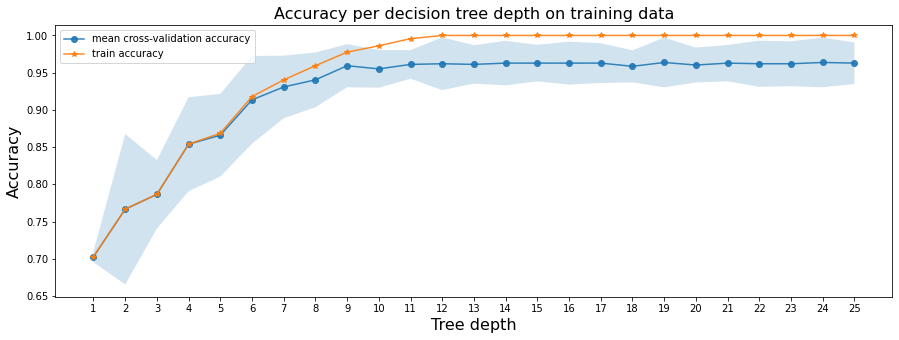

In [ ]:
# fitting trees of depth 1 to 25
sm_tree_depths = range(1,26)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

As shown above, from depth 9 onwards, there's not much difference.<br>
We can use depth 9 as the optimal tree depth.